# Анализ A/A/B-эксперимента

Мы работаем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения. <br>
Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах. <br>
Исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

## Изучение общей информации, подготовка данных к анализу

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
from pandas.plotting import register_matplotlib_converters

import warnings
warnings.filterwarnings('ignore')

In [2]:
logs = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')

In [3]:
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Каждая запись в логе — это действие пользователя, или событие.

## Подготовка данных

In [5]:
logs.columns = ['event_name', 'user_id', 'event_time', 'exp_id']

 Данные содержат:
 - event_name — название события;
 - user_id — уникальный идентификатор пользователя;
 - event_time — время события;
 - exp_id — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Посмотрим на пропуски в данных.

In [6]:
(logs.isna().sum()/len(logs)) * 100

event_name    0.0
user_id       0.0
event_time    0.0
exp_id        0.0
dtype: float64

Пропусков в данных нет.

Типы данных:
 - название события - тип данных object (текст),
 - уникальный идентификатор пользователя - целые числа (int64),
 - время события,
 - номер эксперимента - целые числа, с целью экономии памяти заменим на целые числа размером 2 байта

In [7]:
logs['exp_id'] = logs['exp_id'].astype('int16')

In [8]:
# посмотрим на дубликаты
logs.duplicated().sum()

413

In [9]:
logs = logs.drop_duplicates()

In [10]:
# добавим столбец даты и времени
logs['date_time'] = pd.to_datetime(logs['event_time'], unit='s')

In [11]:
# добавим столбец даты 
logs['date'] = logs['date_time'].dt.date
logs['date'] = pd.to_datetime(logs['date'])

In [12]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
event_name    243713 non-null object
user_id       243713 non-null int64
event_time    243713 non-null int64
exp_id        243713 non-null int16
date_time     243713 non-null datetime64[ns]
date          243713 non-null datetime64[ns]
dtypes: datetime64[ns](2), int16(1), int64(2), object(1)
memory usage: 11.6+ MB


**Вывод**
1. Положили данные о действиях пользователей в переменную.
2. Заменили названия столбцов.
3. Проверили пропуски и типы данных.
4. Добавили столбцы даты и времени и отдельный столбец с датой.

## Изучение и проверка данных

### Всего событий в логе

In [13]:
logs_value_counts = logs['event_name'].value_counts()
logs_value_counts

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Всего 5 типов событий в логе:
 - MainScreenAppear - главный экран,
 - OffersScreenAppear - экран предложения,
 - CartScreenAppear - экран корзины, 
 - PaymentScreenSuccessful - успешное завершение оплаты,
 - Tutorial - руководство

In [14]:
print('Общая сумма событий в логе: {:.0f}'.format(logs_value_counts.sum()))

Общая сумма событий в логе: 243713


### Всего пользователей в логе

In [15]:
print('Всего пользователей в логе: {:.0f}'.format(logs['user_id'].nunique()))

Всего пользователей в логе: 7551


### Среднее количество событий на пользователя

In [16]:
round(len(logs['event_name']) / logs['user_id'].nunique())

32

In [17]:
logs.head()

,event_name,user_id,event_time,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


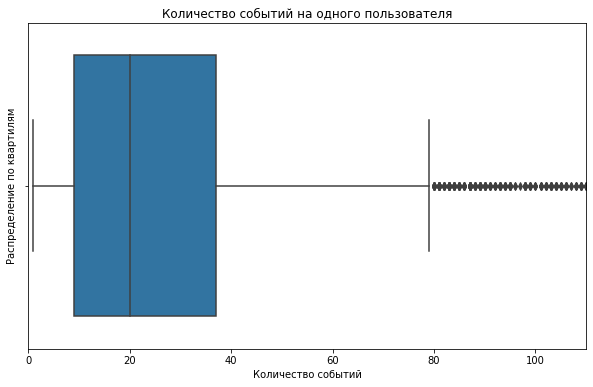

In [18]:
plt.figure(figsize=(10,6))
ax = logs.groupby('user_id')['event_name'].count()
sns.boxplot(x=ax, data = logs)
plt.title('Количество событий на одного пользователя')
plt.xlabel('Количество событий')
plt.ylabel('Распределение по квартилям')
plt.xlim(0,110)
plt.show()

In [19]:
ax.describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

 - Минимальное значение по выборке равно 1му событию на пользователя
 - Нижний квартиль - 25 % выборки находится в пределах 9 собыий 
 - Медина делит выборку на 2 равные части и равна 20
 - Верхний квартиль равен 37

In [20]:
display(ax.median())
display(ax.mode())

20.0

0    5
dtype: int64

В среднем на 1 пользователя приходится 32 события. Медианное количество событий на пользователя равно 20, модальное - 5.

### Период проведения эксперимента

In [21]:
logs['date_time'].min()

Timestamp('2019-07-25 04:43:36')

In [22]:
logs['date_time'].max()

Timestamp('2019-08-07 21:15:17')

Эксперимент длился с 25.07.2019 по 07.08.2019.

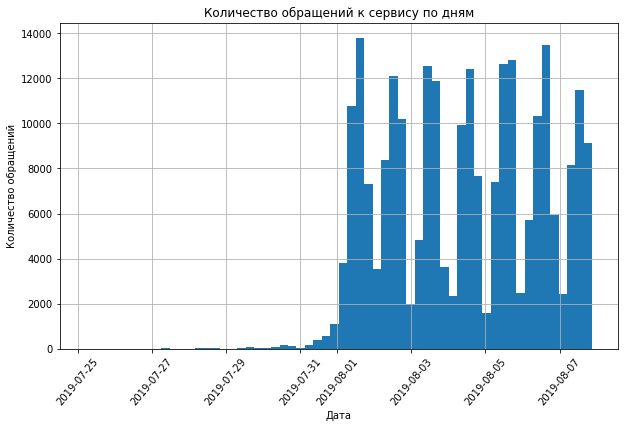

In [23]:
register_matplotlib_converters()
plt.figure(figsize=(10,6))
ax = logs['date_time'].hist(bins=60)
plt.title('Количество обращений к сервису по дням')
plt.xlabel('Дата')
plt.ylabel('Количество обращений')
plt.xticks(rotation=50)
plt.show()

In [24]:
logs_pivot = logs.pivot_table(index='date', values = 'event_name', aggfunc='count')
logs_pivot.columns = ['event_count']
logs_pivot

,event_count
date,
2019-07-25,9
2019-07-26,31
2019-07-27,55
2019-07-28,105
2019-07-29,184
2019-07-30,412
2019-07-31,2030
2019-08-01,36141
2019-08-02,35554


In [25]:
display(len(logs[(logs['date_time'] >= '2019-07-31 00:00:00') & (logs['date_time'] <= '2019-08-01 00:00:00')]))
display(len(logs[(logs['date_time'] >= '2019-07-31 12:00:00') & (logs['date_time'] <= '2019-08-01 00:00:00')]))
display(len(logs[(logs['date_time'] >= '2019-07-31 19:00:00') & (logs['date_time'] <= '2019-08-01 00:00:00')]))

2030

1667

958

В период с 19 часов вечера до конца дня 31 июля было 958 обращений к сервису.

Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». По графику видно, что большинство событий и обращений к сервису начинается с 01.08.2019. Следовательно, отбросим более старые данные и будем работать с периодом 01.08.2019 - 07.08.2019.

In [26]:
date_query = '2019-07-31'
logs_clean = logs.query('date > @date_query')

### Посмотрим, сколько событий и пользователей потеряли, отбросив старые данные

In [27]:
print('Всего пользователей после фильтрации данных: {:.0f}'.format(logs_clean['user_id'].nunique()))

Всего пользователей после фильтрации данных: 7534


In [28]:
print('Общая сумма событий после фильтрации данных: {:.0f}'.format(logs_clean['event_name'].value_counts().sum()))

Общая сумма событий после фильтрации данных: 240887


In [29]:
print('После фильтрации данных потеряли: {:.0f} событий, {:.2%} от общего объема данных'.format(logs_value_counts.sum() - \
                                         logs_clean['event_name'].value_counts().sum(), 
                                         1 - (len(logs_clean['event_name']) / len(logs['event_name']))))

После фильтрации данных потеряли: 2826 событий, 1.16% от общего объема данных


In [30]:
print('После фильтрации данных потеряли: {:.0f} пользователей, {:.2%} от общего объема данных'.format(\
                                logs['user_id'].nunique() - logs_clean['user_id'].nunique(), \
                                1 - (logs_clean['user_id'].nunique() / logs['user_id'].nunique())))

После фильтрации данных потеряли: 17 пользователей, 0.23% от общего объема данных


### Посмотрим, что у нас есть пользователи из всех трёх экспериментальных групп

In [31]:
logs_clean.groupby('exp_id').agg({'user_id':'count'})

,user_id
exp_id,
246,79302
247,77022
248,84563


In [32]:
logs_clean.groupby('exp_id').agg({'user_id':'nunique'})

,user_id
exp_id,
246,2484
247,2513
248,2537


246 и 247 — контрольные группы, а 248 — экспериментальная. В трех экспериментальных группах примерно одинаковое количество пользователей.

**Вывод**
1. Общая сумма событий в логе: 243713
2. Всего 5 типов событий в логе:
 - MainScreenAppear - главный экран,
 - OffersScreenAppear - экран предложения,
 - CartScreenAppear - экран корзины, 
 - PaymentScreenSuccessful - успешное завершение оплаты,
 - Tutorial - руководство
3. Всего пользователей в логе: 7551
4. В среднем на 1 пользователя приходится 32 события.
5. Эксперимент длился с 25.07.2019 по 07.08.2019. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». По графику видно, что большинство событий и обращений к сервису начинается с 01.08.2019. Следовательно, отбросим более старые данные и будем работать с периодом 01.08.2019 - 07.08.2019.

## Воронка событий

### Какие события есть в логах, как часто они встречаются

In [33]:
logs_count = logs_clean.groupby('event_name')['user_id'].count().reset_index().sort_values(by='user_id', ascending = False)
logs_count.columns = ['event_name', 'count']
logs_count

,event_name,count
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Всего 5 событий в логе.

### Посмотрим, сколько пользователей совершали каждое из этих событий

In [34]:
logs_unique = logs_clean.groupby('event_name').agg({'user_id': 'nunique'}).reset_index().\
                                             sort_values(by='user_id', ascending = False)
logs_unique.columns = ['event_name', 'user_unique']
logs_unique

,event_name,user_unique
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


### Предположим, в каком порядке происходят события

Знакомство с сервисом у пользователя начинается с главной страницы. Затем пользователь попадает на экран предложения, а затем на экран корзины. После успешного завершения оплаты пользователь попадает на страницу с руководством. Обучение часто пропускают. Все события, кроме обучения, выстраиваются в последовательную цепочку. Можно предположить, что интерфейс продукта доступен и интуитивно понятен пользователям. Этап обучения не будем включать в нашу воронку. 

In [37]:
logs_clean = logs_clean[logs_clean['event_name'] != 'Tutorial']
logs_unique = logs_unique[logs_unique['event_name'] != 'Tutorial']

### Посмотрим, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

In [38]:
logs_unique['conversion'] = logs_unique['user_unique'].apply(lambda x: round((x/7419)*100, 2))

In [39]:
logs_unique['percent'] = None

In [40]:
logs_unique

,event_name,user_unique,conversion,percent
1,MainScreenAppear,7419,100.00,None
2,OffersScreenAppear,4593,61.91,None
0,CartScreenAppear,3734,50.33,None
3,PaymentScreenSuccessful,3539,47.70,None


In [41]:
def percent(df):
    df.iloc[0,3] = 100
    df.iloc[1,3] = round((df.iloc[1,2] / df.iloc[0,2]) * 100,2)
    df.iloc[2,3] = round((df.iloc[2,2] / df.iloc[1,2]) * 100,2)
    df.iloc[3,3] = round((df.iloc[3,2] / df.iloc[2,2]) * 100,2)
    return df

In [42]:
logs_unique = percent(logs_unique)
logs_unique

,event_name,user_unique,conversion,percent
1,MainScreenAppear,7419,100.00,100
2,OffersScreenAppear,4593,61.91,61.91
0,CartScreenAppear,3734,50.33,81.3
3,PaymentScreenSuccessful,3539,47.70,94.77


### На каком шаге теряем больше всего пользователей

Больше всего пользователей теряем на главном экране (~38% пользователей).

### Какая доля пользователей доходит от первого события до оплаты

От посещения главного экрана до успешной оплаты доходит 47,7% пользователей.

**Вывод**
1. Знакомство с сервисом у пользователя начинается с главной страницы. Затем пользователь попадает на экран предложения, а затем на экран корзины. После успешного завершения оплаты пользователь попадает на страницу с руководством. Обучение часто пропускают. Все события, кроме обучения, выстраиваются в последовательную цепочку. Можно предположить, что интерфейс продукта доступен и интуитивно понятен пользователям. Этап обучения не будем включать в нашу воронку.
2. Больше всего пользователей теряем на главном экране (~38% пользователей).
3. От посещения главного экрана до успешной оплаты доходит 47,7% пользователей.

## Результаты эксперимента

### Сколько пользователей в каждой экспериментальной группе

In [43]:
logs_clean.groupby('exp_id').agg({'user_id': 'nunique'})

,user_id
exp_id,
246,2483
247,2512
248,2535


В каждой группе примерно одинаковое количество пользователей.

### Гипотеза о равенстве конверсий в двух контрольных группах (A/A-тест)

In [44]:
group_A_246 = logs_clean.loc[(logs_clean['exp_id'] == 246) & (logs_clean['event_name'] != 'Tutorial')]
group_A_247 = logs_clean.loc[(logs_clean['exp_id'] == 247) & (logs_clean['event_name'] != 'Tutorial')]
group_B_248 = logs_clean.loc[(logs_clean['exp_id'] == 248) & (logs_clean['event_name'] != 'Tutorial')]

In [45]:
group_A_246_count = group_A_246.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending = False)
group_A_246_count = group_A_246_count.reset_index()
group_A_246_count

,event_name,user_id
0,MainScreenAppear,2450
1,OffersScreenAppear,1542
2,CartScreenAppear,1266
3,PaymentScreenSuccessful,1200


In [46]:
group_A_247_count = group_A_247.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending = False)
group_A_247_count = group_A_247_count.reset_index()
group_A_247_count

,event_name,user_id
0,MainScreenAppear,2476
1,OffersScreenAppear,1520
2,CartScreenAppear,1238
3,PaymentScreenSuccessful,1158


In [47]:
def test_conversion(group1, group2, event_trial, event_successe):
    alpha = .05 # критический уровень статистической значимости
    # число успехов 
    successes1 = group1[group1['event_name'] == event_successe]['user_id'].values[0]
    successes2 = group2[group2['event_name'] == event_successe]['user_id'].values[0]
    # число попыток
    trials1 = group1[group1['event_name'] == event_trial]['user_id'].values[0]
    trials2 = group2[group2['event_name'] == event_trial]['user_id'].values[0]
    results = proportions_ztest([successes1, successes2], [trials1, trials2])
    print('p-value: {:.5f}'.format(results[1]))
    if (results[1] < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

Гипотеза. Конверсия из MainScreenAppear (главный экран) в OffersScreenAppear (экран предложения) контрольной группы 246 равна конверсии данного события в контрольной группе 247. <br>
HO: Конверсия из MainScreenAppear (главный экран) в OffersScreenAppear (экран предложения) контрольной группы 246 равна конверсии данного события в контрольной группе 247. <br>
Н1: Конверсия из MainScreenAppear (главный экран) в OffersScreenAppear (экран предложения) контрольной группы 246 не равна конверсии данного события в контрольной группе 247.

In [48]:
# конверсия из главного экрана в экран предложения
test_conversion(group_A_246_count, group_A_247_count, 'MainScreenAppear', 'OffersScreenAppear')

p-value: 0.26223
Не получилось отвергнуть нулевую гипотезу


Гипотеза. Конверсия из MainScreenAppear (главный экран) в CartScreenAppear (экран корзины) контрольной группы 246 равна конверсии данного события в контрольной группе 247. <br>
HO: Конверсия из  MainScreenAppear (главный экран) в CartScreenAppear (экран корзины)  контрольной группы 246 равна конверсии данного события в контрольной группе 247. <br>
Н1: Конверсия из  MainScreenAppear (главный экран) в CartScreenAppear (экран корзины)  контрольной группы 246 не равна конверсии данного события в контрольной группе 247.

In [49]:
# конверсия из экрана предложения в экран корзины
test_conversion(group_A_246_count, group_A_247_count, 'MainScreenAppear', 'CartScreenAppear')

p-value: 0.24012
Не получилось отвергнуть нулевую гипотезу


Гипотеза. Конверсия из MainScreenAppear (главный экран) в PaymentScreenSuccessful (завершение оплаты) контрольной группы 246 равна конверсии данного события в контрольной группе 247. <br>
HO: Конверсия из MainScreenAppear (главный экран) в PaymentScreenSuccessful (завершение оплаты) контрольной группы 246 равна конверсии данного события в контрольной группе 247. <br>
Н1: Конверсия из MainScreenAppear (главный экран) в PaymentScreenSuccessful (завершение оплаты) контрольной группы 246 не равна конверсии данного события в контрольной группе 247.

In [50]:
# конверсия из экрана корзины в завершение оплаты
test_conversion(group_A_246_count, group_A_247_count, 'MainScreenAppear', 'PaymentScreenSuccessful')

p-value: 0.12044
Не получилось отвергнуть нулевую гипотезу


P-value больше 5%, статистически значимых отличий в конверсиях между выборками нет.

### Гипотеза о равенстве долей пользователей, совершивших событие к общему числу пользователей (А/А-тест)

In [51]:
def test_success(group1, group2, event_name):
    alpha = .05 # критический уровень статистической значимости
    # число успехов 
    successes1 = group1.loc[group1['event_name'] == event_name]['user_id'].nunique()
    successes2 = group2.loc[group2['event_name'] == event_name]['user_id'].nunique()
    # число попыток
    trials1 = group1['user_id'].nunique()
    trials2 = group2['user_id'].nunique()
    results = proportions_ztest([successes1, successes2], [trials1, trials2])
    print('p-value: {:.5f}'.format(results[1]))
    if (results[1] < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

Гипотеза. Доля пользователей, совершивших событие MainScreenAppear (открытие главного экрана) к общему числу пользователей в контрольных группах 246 и 247 равны. <br>
HO: Доля пользователей, совершивших событие MainScreenAppear (открытие главного экрана) к общему числу пользователей в контрольных группах 246 и 247 равны. <br>
Н1: Доля пользователей, совершивших событие MainScreenAppear (открытие главного экрана) к общему числу пользователей в контрольных группах 246 и 247 не равны. <br>

In [52]:
test_success(group_A_246, group_A_247, 'MainScreenAppear')

p-value: 0.75267
Не получилось отвергнуть нулевую гипотезу


Гипотеза. Доля пользователей, совершивших событие OffersScreenAppear (открытие экрана предложения) к общему числу пользователей в контрольных группах 246 и 247 равны. <br>
HO: Доля пользователей, совершивших событие OffersScreenAppear (открытие экрана предложения) к общему числу пользователей в контрольных группах 246 и 247 равны. <br>
Н1: Доля пользователей, совершивших событие OffersScreenAppear (открытие экрана предложения) к общему числу пользователей в контрольных группах 246 и 247 не равны. <br>

In [53]:
test_success(group_A_246, group_A_247, 'OffersScreenAppear')

p-value: 0.24786
Не получилось отвергнуть нулевую гипотезу


Гипотеза. Доля пользователей, совершивших событие CartScreenAppear (открытие экрана корзины) к общему числу пользователей в контрольных группах 246 и 247 равны. <br>
HO: Доля пользователей, совершивших событие CartScreenAppear (открытие экрана корзины) к общему числу пользователей в контрольных группах 246 и 247 равны. <br>
Н1: Доля пользователей, совершивших событие CartScreenAppear (открытие экрана корзины) к общему числу пользователей в контрольных группах 246 и 247 не равны. <br>

In [54]:
test_success(group_A_246, group_A_247, 'CartScreenAppear')

p-value: 0.22868
Не получилось отвергнуть нулевую гипотезу


Гипотеза. Доля пользователей, совершивших событие PaymentScreenSuccessful (завершение оплаты) к общему числу пользователей в контрольных группах 246 и 247 равны. <br>
HO: Доля пользователей, совершивших событие PaymentScreenSuccessful (завершение оплаты) к общему числу пользователей в контрольных группах 246 и 247 равны. <br>
Н1: Доля пользователей, совершивших событие PaymentScreenSuccessful (завершение оплаты) к общему числу пользователей в контрольных группах 246 и 247 не равны. <br>

In [55]:
test_success(group_A_246, group_A_247, 'PaymentScreenSuccessful')

p-value: 0.11447
Не получилось отвергнуть нулевую гипотезу


P-value больше 5%, статистически значимых отличий в долях между выборками нет.

###  Гипотеза о равенстве долей пользователей, совершивших событие к общему числу пользователей (А/В-тест)

Гипотеза. Доля пользователей, совершивших событие MainScreenAppear (открытие главного экрана) к общему числу пользователей в контрольной группе 246 и экспериментальной группе 248 равны. <br>
HO: Доля пользователей, совершивших событие MainScreenAppear (открытие главного экрана) к общему числу пользователей в контрольной группе 246 и экспериментальной группе 248 равны. <br>
Н1: Доля пользователей, совершивших событие MainScreenAppear (открытие главного экрана) к общему числу пользователей в контрольной группе 246 и экспериментальной группе 248 не равны. <br>

In [56]:
test_success(group_A_246, group_B_248, 'MainScreenAppear')

p-value: 0.33871
Не получилось отвергнуть нулевую гипотезу


Гипотеза. Доля пользователей, совершивших событие OffersScreenAppear (открытие экрана предложения) к общему числу пользователей в контрольной группе 246 и экспериментальной группе 248 равны. <br>
HO: Доля пользователей, совершивших событие OffersScreenAppear (открытие экрана предложения) к общему числу пользователей в контрольной группе 246 и экспериментальной группе 248 равны. <br>
Н1: Доля пользователей, совершивших событие OffersScreenAppear (открытие экрана предложения) к общему числу пользователей в контрольной группе 246 и экспериментальной группе 248 не равны. <br>

In [57]:
test_success(group_A_246, group_B_248, 'OffersScreenAppear')

p-value: 0.21442
Не получилось отвергнуть нулевую гипотезу


Гипотеза. Доля пользователей, совершивших событие CartScreenAppear (открытие экрана корзины) к общему числу пользователей в контрольной группе 246 и экспериментальной группе 248 равны. <br>
HO: Доля пользователей, совершивших событие CartScreenAppear (открытие экрана корзины) к общему числу пользователей в контрольной группе 246 и экспериментальной группе 248 равны. <br>
Н1: Доля пользователей, совершивших событие CartScreenAppear (открытие экрана корзины) к общему числу пользователей в контрольной группе 246 и экспериментальной группе 248 не равны. <br>

In [58]:
test_success(group_A_246, group_B_248, 'CartScreenAppear')

p-value: 0.08067
Не получилось отвергнуть нулевую гипотезу


Гипотеза. Доля пользователей, совершивших событие PaymentScreenSuccessful (завершение оплаты) к общему числу пользователей в контрольной группе 246 и экспериментальной группе 248 равны. <br>
HO: Доля пользователей, совершивших событие PaymentScreenSuccessful (завершение оплаты) к общему числу пользователей в контрольной группе 246 и экспериментальной группе 248 равны. <br>
Н1: Доля пользователей, совершивших событие PaymentScreenSuccessful (завершение оплаты) к общему числу пользователей в контрольной группе 246 и экспериментальной группе 248 не равны. <br>

In [59]:
test_success(group_A_246, group_B_248, 'PaymentScreenSuccessful')

p-value: 0.21693
Не получилось отвергнуть нулевую гипотезу


Гипотеза. Доля пользователей, совершивших событие MainScreenAppear (открытие главного экрана) к общему числу пользователей в контрольной группе 247 и экспериментальной группе 248 равны. <br>
HO: Доля пользователей, совершивших событие MainScreenAppear (открытие главного экрана) к общему числу пользователей в контрольной группе 247 и экспериментальной группе 248 равны. <br>
Н1: Доля пользователей, совершивших событие MainScreenAppear (открытие главного экрана) к общему числу пользователей в контрольной группе 247 и экспериментальной группе 248 не равны. <br>

In [60]:
test_success(group_A_247, group_B_248, 'MainScreenAppear')

p-value: 0.51950
Не получилось отвергнуть нулевую гипотезу


Гипотеза. Доля пользователей, совершивших событие OffersScreenAppear (открытие экрана предложения) к общему числу пользователей в контрольной группе 247 и экспериментальной группе 248 равны. <br>
HO: Доля пользователей, совершивших событие OffersScreenAppear (открытие экрана предложения) к общему числу пользователей в контрольной группе 247 и экспериментальной группе 248 равны. <br>
Н1: Доля пользователей, совершивших событие OffersScreenAppear (открытие экрана предложения) к общему числу пользователей в контрольной группе 247 и экспериментальной группе 248 не равны. <br>

In [61]:
test_success(group_A_247, group_B_248, 'OffersScreenAppear')

p-value: 0.93338
Не получилось отвергнуть нулевую гипотезу


Гипотеза. Доля пользователей, совершивших событие CartScreenAppear (открытие экрана корзины) к общему числу пользователей в контрольной группе 247 и экспериментальной группе 248 равны. <br>
HO: Доля пользователей, совершивших событие CartScreenAppear (открытие экрана корзины) к общему числу пользователей в контрольной группе 247 и экспериментальной группе 248 равны. <br>
Н1: Доля пользователей, совершивших событие CartScreenAppear (открытие экрана корзины) к общему числу пользователей в контрольной группе 247 и экспериментальной группе 248 не равны. <br>

In [62]:
test_success(group_A_247, group_B_248, 'CartScreenAppear')

p-value: 0.58783
Не получилось отвергнуть нулевую гипотезу


Гипотеза. Доля пользователей, совершивших событие PaymentScreenSuccessful (завершение оплаты) к общему числу пользователей в контрольной группе 247 и экспериментальной группе 248 равны. <br>
HO: Доля пользователей, совершивших событие PaymentScreenSuccessful (завершение оплаты) к общему числу пользователей в контрольной группе 247 и экспериментальной группе 248 равны. <br>
Н1: Доля пользователей, совершивших событие PaymentScreenSuccessful (завершение оплаты) к общему числу пользователей в контрольной группе 247 и экспериментальной группе 248 не равны. <br>

In [63]:
test_success(group_A_247, group_B_248, 'PaymentScreenSuccessful')

p-value: 0.72757
Не получилось отвергнуть нулевую гипотезу


Гипотеза. Доля пользователей, совершивших событие PaymentScreenSuccessful (завершение оплаты) к общему числу пользователей в контрольной группе 247 и экспериментальной группе 248 равны. <br>
HO: Доля пользователей, совершивших событие PaymentScreenSuccessful (завершение оплаты) к общему числу пользователей в контрольной группе 247 и экспериментальной группе 248 равны. <br>
Н1: Доля пользователей, совершивших событие PaymentScreenSuccessful (завершение оплаты) к общему числу пользователей в контрольной группе 247 и экспериментальной группе 248 не равны. <br>

In [64]:
group_246_and_247 = logs_clean.loc[(logs_clean['exp_id'] == 246) | (logs_clean['exp_id'] == 247)\
                                   & (logs_clean['event_name'] != 'Tutorial')]

Гипотеза. Доля пользователей, совершивших событие MainScreenAppear (открытие главного экрана) к общему числу пользователей в объединенной контрольной группе (246 и 247) и экспериментальной группе 248 равны. <br>
HO: Доля пользователей, совершивших событие MainScreenAppear (открытие главного экрана) к общему числу пользователей в объединенной контрольной группе (246 и 247) и экспериментальной группе 248 равны. <br>
Н1: Доля пользователей, совершивших событие MainScreenAppear (открытие главного экрана) к общему числу пользователей в объединенной контрольной группе (246 и 247) и экспериментальной группе 248 не равны. <br>

In [65]:
test_success(group_246_and_247, group_B_248, 'MainScreenAppear')

p-value: 0.34867
Не получилось отвергнуть нулевую гипотезу


Гипотеза. Доля пользователей, совершивших событие OffersScreenAppear (открытие экрана предложения) к общему числу пользователей в объединенной контрольной группе (246 и 247) и экспериментальной группе 248 равны. <br>
HO: Доля пользователей, совершивших событие OffersScreenAppear (открытие экрана предложения) к общему числу пользователей в объединенной контрольной группе (246 и 247) и экспериментальной группе 248 равны. <br>
Н1: Доля пользователей, совершивших событие OffersScreenAppear (открытие экрана предложения) к общему числу пользователей в объединенной контрольной группе (246 и 247) и экспериментальной группе 248 не равны. <br>

In [66]:
test_success(group_246_and_247, group_B_248, 'OffersScreenAppear')

p-value: 0.44583
Не получилось отвергнуть нулевую гипотезу


Гипотеза. Доля пользователей, совершивших событие CartScreenAppear (открытие экрана корзины) к общему числу пользователей в объединенной контрольной группе (246 и 247) и экспериментальной группе 248 равны. <br>
HO: Доля пользователей, совершивших событие CartScreenAppear (открытие экрана корзины) к общему числу пользователей в объединенной контрольной группе (246 и 247) и экспериментальной группе 248 равны. <br>
Н1: Доля пользователей, совершивших событие CartScreenAppear (открытие экрана корзины) к общему числу пользователей в объединенной контрольной группе (246 и 247) и экспериментальной группе 248 не равны. <br>

In [67]:
test_success(group_246_and_247, group_B_248, 'CartScreenAppear')

p-value: 0.18684
Не получилось отвергнуть нулевую гипотезу


Гипотеза. Доля пользователей, совершивших событие PaymentScreenSuccessful (завершение оплаты) к общему числу пользователей в объединенной контрольной группе (246 и 247) и экспериментальной группе 248 равны. <br>
HO: Доля пользователей, совершивших событие PaymentScreenSuccessful (завершение оплаты) к общему числу пользователей в объединенной контрольной группе (246 и 247) и экспериментальной группе 248 равны. <br>
Н1: Доля пользователей, совершивших событие PaymentScreenSuccessful (завершение оплаты) к общему числу пользователей в объединенной контрольной группе (246 и 247) и экспериментальной группе 248 не равны. <br>

In [68]:
test_success(group_246_and_247, group_B_248, 'PaymentScreenSuccessful')

p-value: 0.61079
Не получилось отвергнуть нулевую гипотезу


P-value больше 5%, статистически значимых отличий в долях между выборками нет.

### Выбор уровня значимости при проверке статистических гипотез

Всего было проведено 16 тестов по проверке гипотезы о равенстве долей пользователей, совершивших событие к общему числу пользователей:
 - 4 А/А-теста 
 - 12 A/B-тестов 

In [69]:
# изменим уровень статистической значимости с помощью поправки Бонферрони
def test_success_with_bonferroni(group1, group2, event_name):
    alpha = .05 # критический уровень статистической значимости
    # число успехов 
    successes1 = group1.loc[group1['event_name'] == event_name]['user_id'].nunique()
    successes2 = group2.loc[group2['event_name'] == event_name]['user_id'].nunique()
    # число попыток
    trials1 = group1['user_id'].nunique()
    trials2 = group2['user_id'].nunique()
    results = proportions_ztest([successes1, successes2], [trials1, trials2])
    print('p-value: {:.5f}'.format(results[1]))
    bonferroni_alpha = alpha / 16 
    if (results[1] < bonferroni_alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

Гипотеза. Доля пользователей, совершивших исследуемое событие к общему числу пользователей в  группах равны. <br>
HO: Доля пользователей, совершивших исследуемое событие к общему числу пользователей в группах равны. <br>
Н1: Доля пользователей, совершивших исследуемое событие к общему числу пользователей в группах не равны.

In [70]:
test_success_with_bonferroni(group_A_246, group_A_247, 'MainScreenAppear')

p-value: 0.75267
Не получилось отвергнуть нулевую гипотезу


In [71]:
test_success_with_bonferroni(group_A_246, group_A_247, 'OffersScreenAppear')

p-value: 0.24786
Не получилось отвергнуть нулевую гипотезу


In [72]:
test_success_with_bonferroni(group_A_246, group_A_247, 'CartScreenAppear')

p-value: 0.22868
Не получилось отвергнуть нулевую гипотезу


In [73]:
test_success_with_bonferroni(group_A_246, group_A_247, 'PaymentScreenSuccessful')

p-value: 0.11447
Не получилось отвергнуть нулевую гипотезу


In [74]:
test_success_with_bonferroni(group_A_246, group_B_248, 'MainScreenAppear')

p-value: 0.33871
Не получилось отвергнуть нулевую гипотезу


In [75]:
test_success_with_bonferroni(group_A_246, group_B_248, 'OffersScreenAppear')

p-value: 0.21442
Не получилось отвергнуть нулевую гипотезу


In [76]:
test_success_with_bonferroni(group_A_246, group_B_248, 'CartScreenAppear')

p-value: 0.08067
Не получилось отвергнуть нулевую гипотезу


In [77]:
test_success_with_bonferroni(group_A_246, group_B_248, 'PaymentScreenSuccessful')

p-value: 0.21693
Не получилось отвергнуть нулевую гипотезу


In [78]:
test_success_with_bonferroni(group_A_247, group_B_248, 'MainScreenAppear')

p-value: 0.51950
Не получилось отвергнуть нулевую гипотезу


In [79]:
test_success_with_bonferroni(group_A_247, group_B_248, 'OffersScreenAppear')

p-value: 0.93338
Не получилось отвергнуть нулевую гипотезу


In [80]:
test_success_with_bonferroni(group_A_247, group_B_248, 'CartScreenAppear')

p-value: 0.58783
Не получилось отвергнуть нулевую гипотезу


In [81]:
test_success_with_bonferroni(group_A_247, group_B_248, 'PaymentScreenSuccessful')

p-value: 0.72757
Не получилось отвергнуть нулевую гипотезу


In [82]:
test_success_with_bonferroni(group_246_and_247, group_B_248, 'MainScreenAppear')

p-value: 0.34867
Не получилось отвергнуть нулевую гипотезу


In [83]:
test_success_with_bonferroni(group_246_and_247, group_B_248, 'OffersScreenAppear')

p-value: 0.44583
Не получилось отвергнуть нулевую гипотезу


In [84]:
test_success_with_bonferroni(group_246_and_247, group_B_248, 'CartScreenAppear')

p-value: 0.18684
Не получилось отвергнуть нулевую гипотезу


In [85]:
test_success_with_bonferroni(group_246_and_247, group_B_248, 'PaymentScreenSuccessful')

p-value: 0.61079
Не получилось отвергнуть нулевую гипотезу


Статистически значимых отличий в долях между выборками нет.

## Общий вывод
1. Всего 5 типов событий в логе:
 - MainScreenAppear - главный экран,
 - OffersScreenAppear - экран предложения,
 - CartScreenAppear - экран корзины,
 - PaymentScreenSuccessful - успешное завершение оплаты,
 - Tutorial - руководство
2. Общая сумма событий в логе: 243713
3. Всего пользователей в логе: 7551
4. Анализ проводили по периоду 01.08.2019 - 07.08.2019.
5. Знакомство с сервисом у пользователя начинается с главной страницы. Затем пользователь попадает на экран предложения, а затем на экран корзины. После успешного завершения оплаты пользователь попадает на страницу с руководством. Обучение часто пропускают. Все события, кроме обучения, выстраиваются в последовательную цепочку. Можно предположить, что интерфейс продукта доступен и интуитивно понятен пользователям. Этап обучения не будем включать в нашу воронку.
6. Больше всего пользователей теряем на главном экране (~38% пользователей).
7. От посещения главного экрана до успешной оплаты доходит 47,7% пользователей.
8. При проведении анализа не выявлено статистически значимых отличий в конверсиях и долях между контрольными выборками. Проведение А/В тестирования показало, что нет статистически значимых отличий в долях между: 
 - контрольной группой 246 и экспериментальной 248, 
 - контрольной группой 247 и экспериментальной 248,
 - объединённой контрольной группой (246+247) и экспериментальной 248.
 
Нет оснований утверждать, что изменение шрифта влияет на пользователей.